# Hotdog vs Not Hotdog 🍞🌭  
Binary Image Classification with Transfer Learning (MobileNetV2)

This notebook trains a binary image classifier that predicts whether an image **contains a hotdog or not**.

- **Dataset:** [Kaggle – Hot Dog / Not Hot Dog](https://www.kaggle.com/datasets/dansbecker/hot-dog-not-hot-dog)
- **Model:** MobileNetV2 (pretrained on ImageNet) + custom classifier head
- **Frameworks:** TensorFlow / Keras, scikit-learn
- **Key Techniques:**
  - Transfer learning
  - Data augmentation
  - Train / validation / test split
  - Confusion matrix & classification report
  - Single-image prediction demo

> Goal: Reproduce the “SeeFood” app idea from the TV show *Silicon Valley* and show a clean ML workflow end-to-end.


## 2. Load Dataset

I use the *Hot Dog / Not Hot Dog* dataset.  
The images are organized in the following folder structure:

- `raw/train/hot_dog`
- `raw/train/not_hot_dog`
- `raw/test/hot_dog`
- `raw/test/not_hot_dog`


In [4]:
!rm -rf raw
!unzip raw.zip -d .

Archive:  raw.zip
   creating: ./raw/
  inflating: ./__MACOSX/._raw        
  inflating: ./raw/.DS_Store         
  inflating: ./__MACOSX/raw/._.DS_Store  
   creating: ./raw/test/
  inflating: ./__MACOSX/raw/._test   
  inflating: ./raw/.gitkeep          
  inflating: ./__MACOSX/raw/._.gitkeep  
   creating: ./raw/train/
  inflating: ./__MACOSX/raw/._train  
  inflating: ./raw/test/.DS_Store    
  inflating: ./__MACOSX/raw/test/._.DS_Store  
   creating: ./raw/test/not_hot_dog/
  inflating: ./__MACOSX/raw/test/._not_hot_dog  
   creating: ./raw/test/hot_dog/
  inflating: ./__MACOSX/raw/test/._hot_dog  
  inflating: ./raw/train/.DS_Store   
  inflating: ./__MACOSX/raw/train/._.DS_Store  
   creating: ./raw/train/not_hot_dog/
  inflating: ./__MACOSX/raw/train/._not_hot_dog  
   creating: ./raw/train/hot_dog/
  inflating: ./__MACOSX/raw/train/._hot_dog  
  inflating: ./raw/test/not_hot_dog/76271.jpg  
  inflating: ./__MACOSX/raw/test/not_hot_dog/._76271.jpg  
  inflating: ./raw/test/not_

In [2]:
!pip install -q tensorflow scikit-learn

## 1. Setup & Imports

Install and import the main libraries we will use: TensorFlow / Keras, NumPy, Matplotlib and scikit-learn.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

## 3. Dataset Split: Train / Validation / Test

I load the dataset from the folder structure:

- `raw/train/hot_dog`
- `raw/train/not_hot_dog`
- `raw/test/hot_dog`
- `raw/test/not_hot_dog`

From the **training folder**, we create:  
- **80% training dataset**  
- **20% validation dataset**  
using `tf.keras.preprocessing.image_dataset_from_directory` with `validation_split=0.2`.

The **test set** is loaded separately and never seen during training.


In [5]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "raw/train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "raw/train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "raw/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="binary",
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 498 files belonging to 2 classes.
Using 399 files for training.
Found 498 files belonging to 2 classes.
Using 99 files for validation.
Found 500 files belonging to 2 classes.


## 4. Model: MobileNetV2 + Custom Classifier

I use **MobileNetV2** as a feature extractor (pretrained on ImageNet) and add:

- GlobalAveragePooling layer
- A final Dense layer with sigmoid for binary classification (hotdog vs not_hotdog)
- Data augmentation in front of the model


In [6]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
])

base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. Training

I train the model for 15 epochs and monitor training vs validation accuracy.


In [7]:
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.5561 - loss: 0.7513 - val_accuracy: 0.6061 - val_loss: 0.6849
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5841 - loss: 0.6862 - val_accuracy: 0.6465 - val_loss: 0.6406
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5891 - loss: 0.6826 - val_accuracy: 0.7273 - val_loss: 0.6092
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6449 - loss: 0.6278 - val_accuracy: 0.7576 - val_loss: 0.5820
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7232 - loss: 0.5694 - val_accuracy: 0.7677 - val_loss: 0.5611
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7345 - loss: 0.5521 - val_accuracy: 0.7778 - val_loss: 0.5442
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6818 - loss: 0.5893 - val_accuracy: 0.7980 - val_loss: 0.5238
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7228 - loss: 0.5758 - val_accuracy: 0.8081 - val_loss:

## 6. Training Visualization

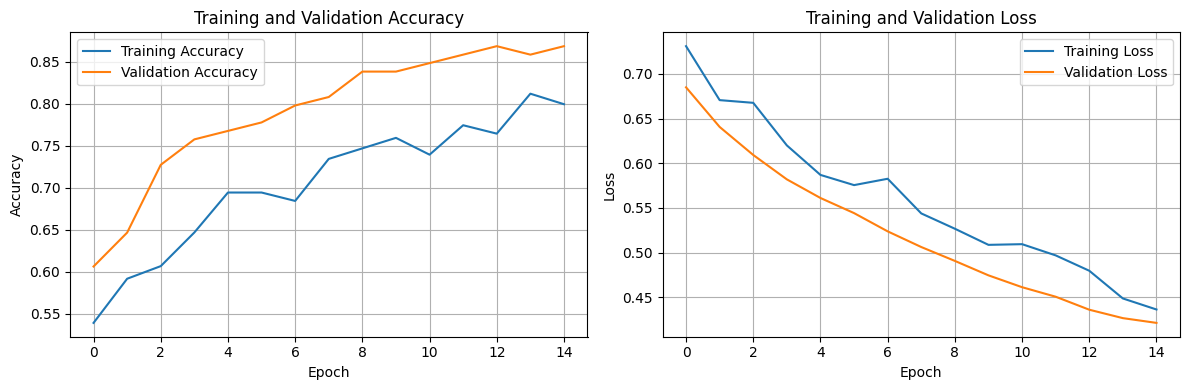

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Test Evaluation

I evaluate on the **held-out test set** and compute:

- Test loss & accuracy
- Confusion matrix
- Precision, recall and F1-score for each class


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_acc = model.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows = gerçek, cols = tahmin):")
print(cm)

target_names = ["hotdog", "not_hotdog"]
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=target_names))


16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8616 - loss: 0.3746
Test loss: 0.40562599897384644
Test accuracy: 0.8500000238418579
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
Confusion matrix (rows = gerçek, cols = tahmin):
[[215  35]
 [ 40 210]]

Classification report:
              precision    recall  f1-score   support

      hotdog       0.84      0.86      0.85       250
  not_hotdog       0.86      0.84      0.85       250

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



**Result summary:**

- Test accuracy ≈ **85%**
- Both classes (hotdog / not_hotdog) have similar precision & recall
- The model makes more mistakes on images with unusual angles, heavy toppings or background clutter.


In [26]:
from tensorflow.keras.preprocessing import image

def predict_one(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = keras.applications.mobilenet_v2.preprocess_input(arr)

    prob = float(model.predict(arr)[0][0])
    label = "HOTDOG 🌭 (class 0)" if prob < 0.5 else "NOT HOTDOG ❌ (class 1)"
    print("Raw prediction score:", prob)
    print("Prediction:", label)

predict_one("raw/test/hot_dog/635712.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Raw prediction score: 0.8567682504653931
Prediction: NOT HOTDOG ❌ (class 1)


## 8. Error Analysis

Below ı visualize a sample of test images with:

- **T:** true label  
- **P:** model prediction  

This helps us understand *what type of images the model still struggles with*.


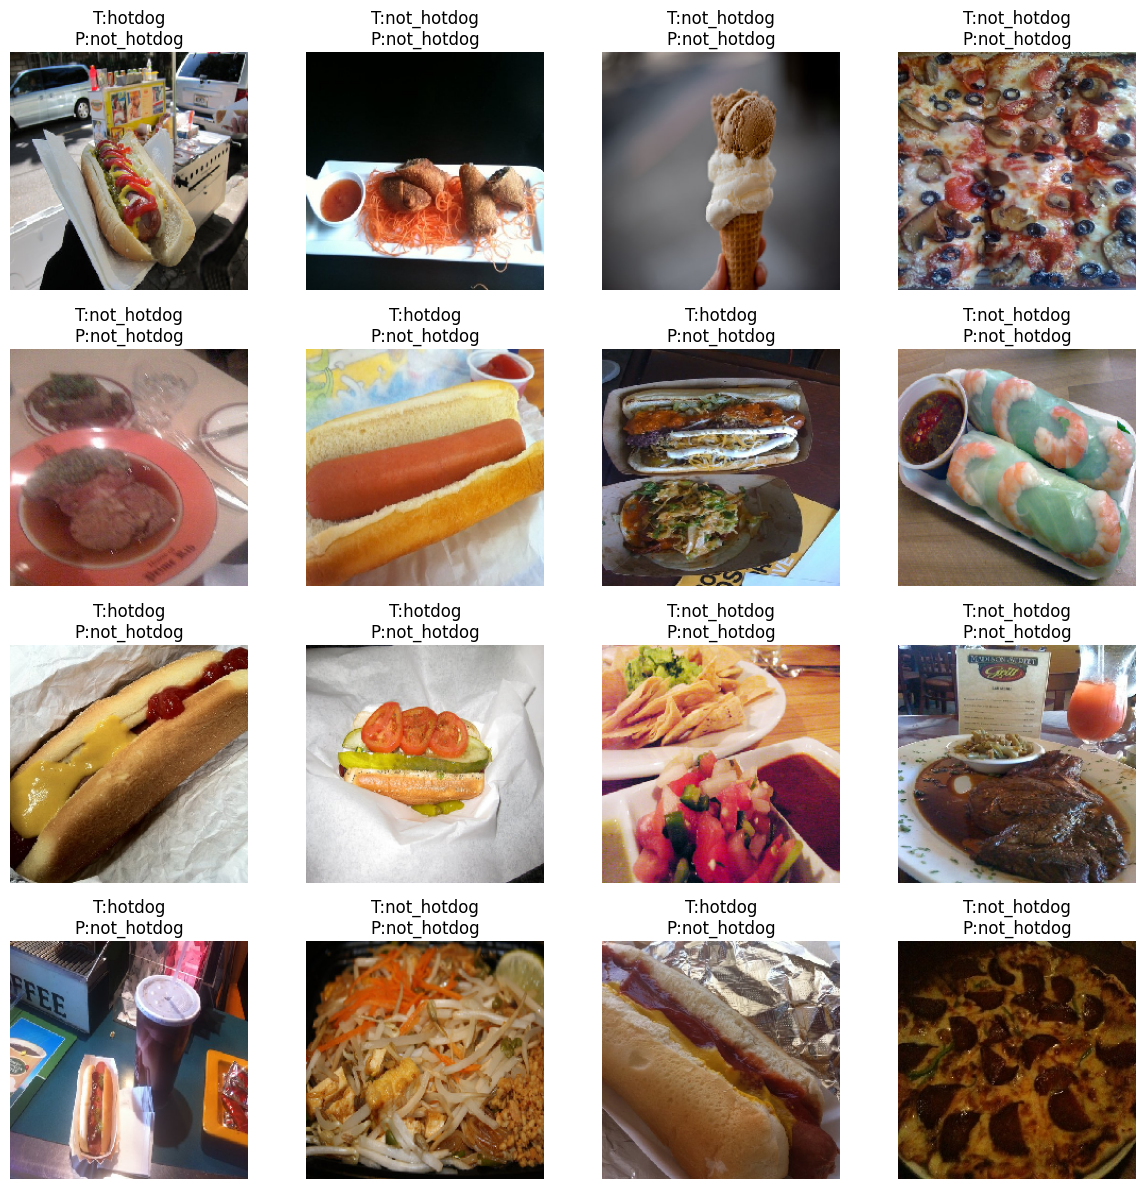

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

IMG_SIZE = (224, 224)

def show_random_examples(n=16):
    hotdog_dir = "raw/test/hot_dog"
    not_dir = "raw/test/not_hot_dog"
    hot_files = [os.path.join(hotdog_dir, f) for f in os.listdir(hotdog_dir)]
    not_files = [os.path.join(not_dir, f) for f in os.listdir(not_dir)]

    all_files = [(f, "hotdog") for f in hot_files] + [(f, "not_hotdog") for f in not_files]
    np.random.shuffle(all_files)
    sample = all_files[:n]

    plt.figure(figsize=(12, 12))
    for i, (path, true_label) in enumerate(sample):
        img = image.load_img(path, target_size=IMG_SIZE)
        arr = image.img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = keras.applications.mobilenet_v2.preprocess_input(arr)
        prob = float(model.predict(arr, verbose=0)[0][0])
        pred_label = "hotdog" if prob < 0.5 else "not_hotdog"

        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{true_label}\nP:{pred_label}")

    plt.tight_layout()
    plt.show()

show_random_examples()
